In [1]:
import numpy as np
import pandas as pd
from methods import GuptaPPCA
from methods import GrassPPCA
from methods import KernelPPCA
from methods import binPCA
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Number of observations
n = 45
# Dimension
D = 3
# Modes
m = 2

# Functions of the model
def mu_true(par):
    return np.zeros((3,np.shape(par)[0]))

def P_true(par):
    p1_true = np.array([np.sin((7*np.pi/1080)*par+0.4), np.tan((7*np.pi/4860)*par-0.8), (49/1800)*par-1.1])
    p2_true = np.array([np.cos((7*np.pi/972)*par), np.cos((7*np.pi/576)*par-0.4), (7/600)*par+1.4])
    return p1_true,p2_true

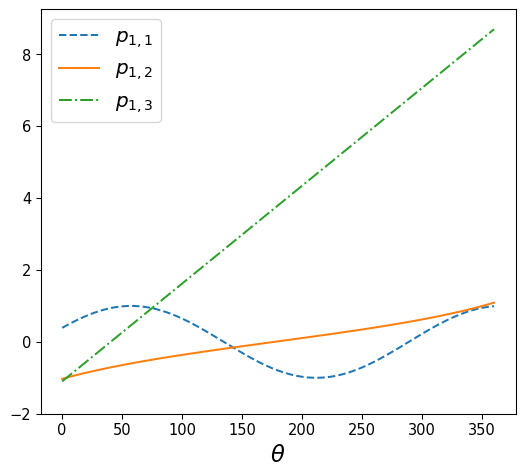

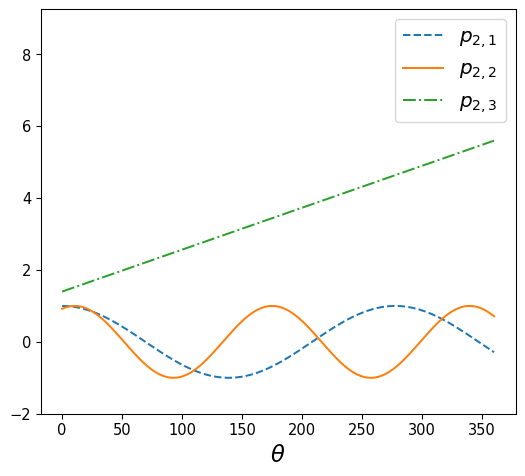

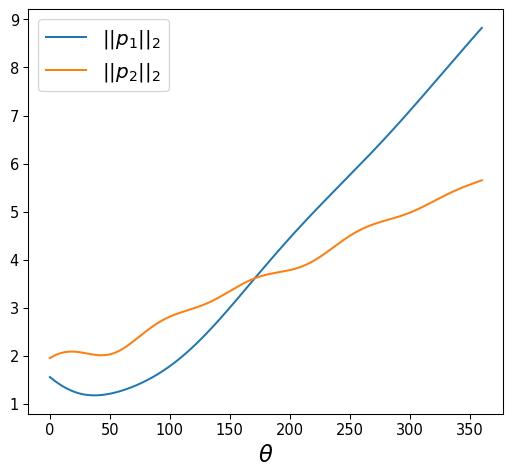

In [3]:
fontsize = 17
my_dpi=96
lines = ['--','-','-.',':','--','--']
theta_plot = np.linspace(0,360,1000)
P = np.stack(P_true(theta_plot))
p1_norm = np.linalg.norm(P[0],axis=0)
p2_norm = np.linalg.norm(P[1],axis=0)

plt.figure(figsize=(613/my_dpi, 525/my_dpi), dpi=my_dpi)
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    
for i in range(D):
    plt.plot(theta_plot,P[0,i],lines[i],label='$p_{1,%d}$'%(i+1))
plt.xlabel("$\\theta$",fontsize=fontsize)
plt.ylim(-2,9.25)
# plt.ylabel("Train RMSE",fontsize=fontsize)
plt.legend()
plt.savefig('../plots_final/ex1/p1',dpi=my_dpi)
# plt.show()

plt.figure(figsize=(613/my_dpi, 525/my_dpi), dpi=my_dpi)
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    
for i in range(D):
    plt.plot(theta_plot,P[1,i],lines[i],label='$p_{2,%d}$'%(i+1))
plt.xlabel("$\\theta$",fontsize=fontsize)
plt.ylim(-2,9.25)
# plt.ylabel("Train RMSE",fontsize=fontsize)
plt.legend()
# plt.savefig('../plots_final/ex1/p2',dpi=my_dpi)
# plt.show()

plt.figure(figsize=(613/my_dpi, 525/my_dpi), dpi=my_dpi)
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    
for i in range(m):
    plt.plot(theta_plot,np.linalg.norm(P[i],axis=0),label='$||p_{%d}||_{2}$'%(i+1))
plt.xlabel("$\\theta$",fontsize=fontsize)
# plt.ylabel("Train RMSE",fontsize=fontsize)
plt.legend()
# plt.savefig('../plots_final/ex1/p1p2norm',dpi=my_dpi)
# plt.show()

# plt.figure(figsize=(613/my_dpi, 525/my_dpi), dpi=my_dpi)
# plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
# plt.rc('legend', fontsize=15)    
# prod = np.zeros(theta_plot.shape)
# for i in range(len(prod)):
#     prod[i] = np.dot(P[0][:,i],P[1][:,i])
# plt.plot(theta_plot,prod)
# plt.xlabel("$\\theta$",fontsize=fontsize)
# # plt.ylabel("Train RMSE",fontsize=fontsize)
# plt.legend()
# # plt.savefig('../plots_final/ex1/p1p2norm',dpi=my_dpi)
# # plt.show()

In [4]:
# total num. of iteration
n_c = 1000
# num. of iteration for bases
n_v = 500
# orthonormality coeff
lambda_0 = 20
# smoothing coeff
lambda_m = 4.2
lambda_v = 0.008

In [5]:
def fixbins(bins, thetadata, m):
    diff = bins.reshape(-1,1)-thetadata.reshape(1,-1)
    ind = (diff<=0).sum(axis=0)-1
    counts = np.histogram(ind, np.arange(len(bins)))[0]
    jmin = counts.argmin()
    if(counts[jmin]<m):
        newbins = list(bins)
        del newbins[jmin]
        return fixbins(np.array(newbins), thetadata, m)
    else:
        return bins

In [6]:
def Sdist_inf(A, B):
    U, S, Vh =np.linalg.svd(A.T@B, full_matrices=False)
    return np.sqrt(1-min(S)**2)

In [7]:
# def Sdist_inf(A, B):
#     U, S, Vh =np.linalg.svd(A.T@B, full_matrices=False)
#     angles = np.arccos(np.clip(S,0,1))
    
#     return np.linalg.norm(angles)

In [8]:
# n_train = 500
split_ratio = 0.4
# training_sizes = np.arange(50,n_train+1,50)
# training_sizes = [500]
n = 500
dev_err = [0.1, 0.25, 0.5, 0.75, 1]
dist_PPCA = []
dist_binPCA = []
dist_grassPCA = []
dist_kerPCA = []
for std_dev in dev_err:
    print(std_dev)
    # Creating training and test set
    np.random.seed(n)
    ntest = 500
    #theta_sample = np.linspace(0,360,int(n*(1+split_ratio)))
    thetadata = 360*np.random.rand(n) #np.linspace(0,360,n)
    #thetadata_test = np.setdiff1d(theta_sample,thetadata)
    thetadata_test = 360*np.random.rand(ntest) # np.sort(np.random.choice(thetadata_test, (int(n*split_ratio),), replace=False))

    #print(beta[:,0].shape)
    beta = np.random.uniform(-1,1,size=(m, n))
    beta_test = np.random.uniform(-1,1,size=(m, ntest))
    noise = np.random.normal(0,std_dev,size=(D, n))
    noise_test = np.random.normal(0,std_dev,size=(D, ntest))
    p1_true,p2_true = P_true(thetadata)
    p1_test,p2_test = P_true(thetadata_test)
    xdata = mu_true(thetadata) + p1_true*beta[0] +p2_true*beta[1] + noise
    xdata = xdata.T
    xdata_test = mu_true(thetadata_test) + p1_test*beta_test[0] +p2_test*beta_test[1] + noise_test
    xdata_test = xdata_test.T

    # Bins construction
    nbins = 14
    # 14 equally spaced bins
    bins = np.linspace(0,360,nbins+1)
    bins = fixbins(bins, thetadata, m)

    nbins = len(bins)-1
    # length of each bin
    bin_length = 360/nbins

    # Bins PCA
    binpca = binPCA(bins,m)
    binpca.fit(thetadata,xdata)

    # PPCA
    gupta = GuptaPPCA(bins,m)
    gupta.fit(thetadata,xdata,maxiter=500,method='L-BFGS-B')

    # Kernel PCA
    def kernel(theta_new, theta_i, gamma=1/200):
        return np.exp(-gamma*((theta_new-theta_i)**2))
    
    kerpca = KernelPPCA(thetadata,xdata,m, kernel)

    # Interpolation PCA
    grass = GrassPPCA(bins,m)
    grass.fit(thetadata,xdata)

    dist_bases_PPCA = []
    dist_bases_binPCA = []
    dist_bases_grassPCA = []
    dist_bases_kerPCA = []

    for b in np.linspace(0,360,1000):
        P = np.array(P_true(b)).T
        Porth = np.linalg.qr(P)[0]
        # print(Sdist_inf(np.linalg.qr(gupta.predict(b))[0],gupta.predict(b)))
        dist_bases_PPCA.append(Sdist_inf(np.linalg.qr(gupta.predict(b))[0],Porth))
        dist_bases_binPCA.append(Sdist_inf(binpca.predict(b),Porth))
        dist_bases_grassPCA.append(Sdist_inf(grass.predict(b),Porth))
        dist_bases_kerPCA.append(Sdist_inf(kerpca.predict(b),Porth))

    dist_PPCA.append(dist_bases_PPCA)
    dist_binPCA.append(dist_bases_binPCA)
    dist_grassPCA.append(dist_bases_grassPCA)
    dist_kerPCA.append(dist_bases_kerPCA)


0.1
0.25
0.5
0.75
1


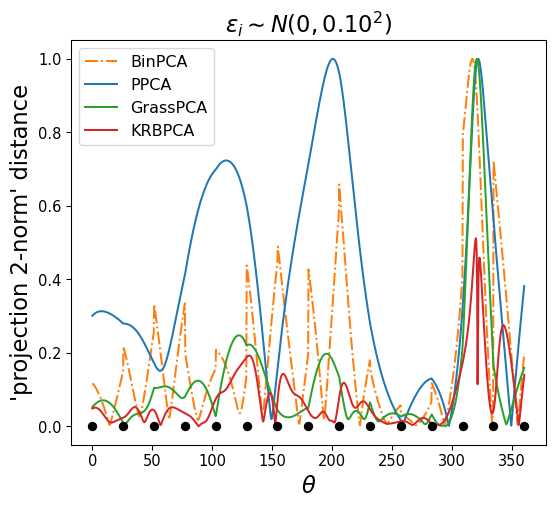

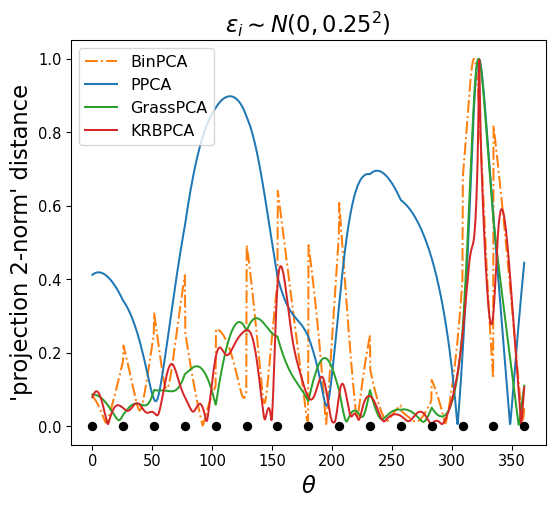

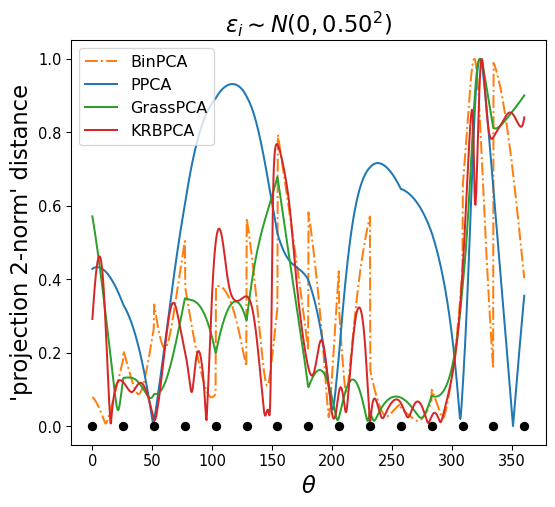

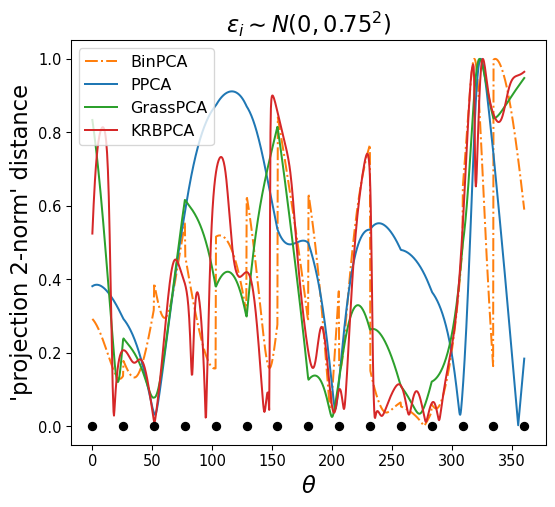

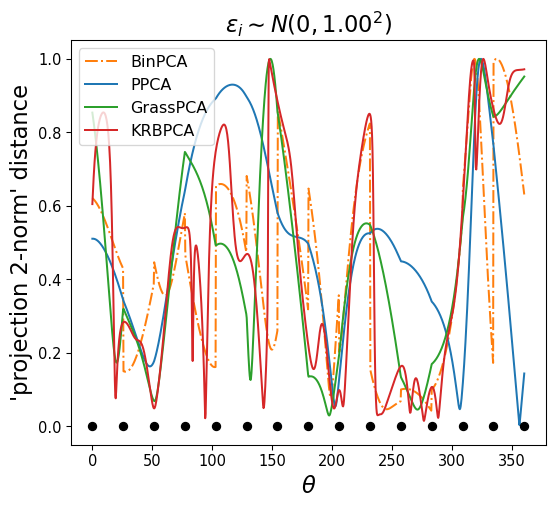

In [9]:
for i in range(len(dev_err)):
    # methods = ["pca", "spca", "binpca", "ppca", "grassmann","kernel"]
    distances = [dist_binPCA,dist_PPCA,dist_grassPCA,dist_kerPCA]
    # labels = ["PCA", "SPCA", "BinPCA", "PPCA", "GrassPCA","KRBPCA"]
    labels = ["BinPCA", "PPCA", "GrassPCA","KRBPCA"]
    markers = ['*','x','o','^','.','s']
    lines = ['-.','-','-','-']
    palette = ['tab:orange','tab:blue','tab:green','tab:red','tab:purple','tab:brown']
    plt.figure(figsize=(613/my_dpi, 525/my_dpi), dpi=my_dpi)
    plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
    plt.rc('legend', fontsize=12)    # legend fontsize
    for j in range(len(distances)):
        plt.plot(np.linspace(0,360,1000),distances[j][i],lines[j],label=labels[j],color=palette[j])
    plt.plot(bins,bins*0,'o',color='k')
    plt.xlabel("$\\theta$",fontsize=fontsize)
    # plt.ylim(0.2,0.8)
    plt.ylabel("\'projection 2-norm\' distance",fontsize=fontsize)
    plt.title("$\\epsilon_{i} \\sim N(0,%.2f^2)$" %dev_err[i],fontsize=fontsize)
    plt.legend()
    # plt.savefig('../plots_final/ex1/bases/'+f'dist{i+1}lbfgsb',dpi=my_dpi)
    # plt.show()

In [10]:
# # TEST
# my_dpi =96
# plt.figure(figsize=(613/my_dpi, 525/my_dpi), dpi=my_dpi)
# plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
# plt.rc('legend', fontsize=12)    # legend fontsize
# plt.plot(np.linspace(0,360,1000),dist_bases_PPCA,'--', label="PPCA")
# plt.plot(np.linspace(0,360,1000),dist_bases_binPCA,'-.', label="binPCA")
# plt.plot(np.linspace(0,360,1000),dist_bases_grassPCA,'--', label="grassPCA")
# plt.plot(np.linspace(0,360,1000),dist_bases_kerPCA,'-', label="KRBPCA")
# plt.plot(bins,0*bins,'.')
# plt.xlabel("$\\theta$",fontsize=15)
# plt.ylabel("distance",fontsize=15)
# plt.legend()
# plt.show()